In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

In [3]:
year_4_data = pd.read_csv("data/4차년도.csv", encoding="cp949")
year_5_data = pd.read_csv("data/5차년도.csv", encoding="cp949")
year_5_data_2 = pd.read_csv("data/5차년도_2차.csv", encoding="cp949")

okt = Okt()

In [4]:
print(f"4 : {len(year_4_data)}, 5_1 : {len(year_5_data)}, 5_2 : {len(year_5_data_2)}")

4 : 14606, 5_1 : 10011, 5_2 : 19374


In [5]:
data = pd.concat((year_4_data,year_5_data,year_5_data_2))
print(len(data))

43991


In [6]:
emotion_dic = {'anger': 0, 'sad': 1, 'neutral': 2, 'happiness': 3, 'sadness': 1, 'angry': 0}


In [7]:
angry_data = pd.concat([data[data['상황']=='anger'], data[data['상황']=='angry']])
sad_data = pd.concat([data[data['상황']=='sad'], data[data['상황']=='sadness']])
neutral_data = data[data['상황']=='neutral']
happy_data = data[data['상황']=='happiness']

data = [angry_data, sad_data, neutral_data, happy_data]

In [11]:
min_n = np.Inf

for i in data:
    if len(i) < min_n:
        min_n = len(i)
print(min_n)

3262


In [20]:
x = []
y = []
for i in data:
    x.append(i.sample(frac=1)[:min_n])
x = pd.concat(x)

for i in x.iloc:
    y.append(emotion_dic[i['상황']])

In [13]:
print(len(x), len(y))

13048 13048


In [21]:
x_origin = x
x = []
for i in x_origin.iloc:
    x.append(okt.morphs(i['발화문']))

In [23]:
len(x)

13048

In [24]:
y = np.array(y)

In [25]:
import pickle
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
x = tokenizer.texts_to_sequences(x)
padded_x = pad_sequences(x, padding='post')

In [26]:
padded_x.shape

(13048, 45)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(padded_x, y, test_size=1, random_state=777)

In [33]:
y_train.shape

(13047,)

In [28]:
maxlen = padded_x.shape[1]

In [38]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(10000, 300, input_length=maxlen), 
  tf.keras.layers.LSTM(units=64, return_sequences=True), 
  tf.keras.layers.LSTM(units=64), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4, activation='softmax')
])

es_callback = tf.keras.callbacks.EarlyStopping('val_loss', 0, 5,)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[es_callback])

Epoch 1/50
164/164 [==============================] - 19s 90ms/step - loss: 1.3880 - accuracy: 0.2448 - val_loss: 1.3876 - val_accuracy: 0.2418
Epoch 2/50
164/164 [==============================] - 13s 82ms/step - loss: 1.2005 - accuracy: 0.4055 - val_loss: 0.7668 - val_accuracy: 0.7126
Epoch 3/50
164/164 [==============================] - 14s 83ms/step - loss: 0.8877 - accuracy: 0.6609 - val_loss: 0.7242 - val_accuracy: 0.7349
Epoch 4/50
164/164 [==============================] - 13s 81ms/step - loss: 0.7708 - accuracy: 0.7023 - val_loss: 0.8380 - val_accuracy: 0.6410
Epoch 5/50
164/164 [==============================] - 13s 82ms/step - loss: 0.7184 - accuracy: 0.7654 - val_loss: 0.7305 - val_accuracy: 0.7410
Epoch 6/50
164/164 [==============================] - 13s 81ms/step - loss: 0.6487 - accuracy: 0.7804 - val_loss: 0.6429 - val_accuracy: 0.7874
Epoch 7/50
164/164 [==============================] - 13s 79ms/step - loss: 0.5752 - accuracy: 0.8237 - val_loss: 0.6381 - val_accuracy:

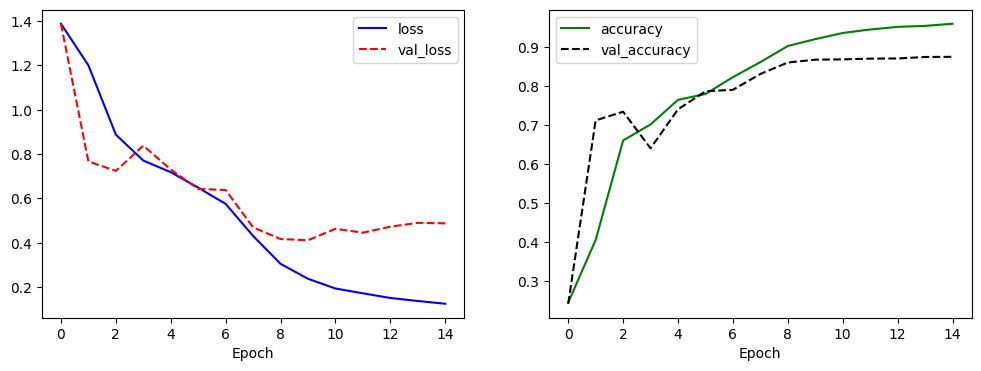

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [45]:
model.save_weights('./lstm/my_checkpoint')

In [44]:
test_sentence = '나는 너무 행복해'
print(1,test_sentence)
test_sentence = [okt.morphs(test_sentence)]
print(2,test_sentence)


test_sentence = tokenizer.texts_to_sequences(test_sentence)
print(3,test_sentence)
test_sentence = pad_sequences(test_sentence, padding='post', maxlen=45)
print(4,test_sentence)

print(model.predict(test_sentence))

1 나는 너무 행복해
2 [['나', '는', '너무', '행복해']]
3 [[2, 5526, 1, 2685]]
4 [[   2 5526    1 2685    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]
1/1 [==============================] - 0s 24ms/step
[[0.00541639 0.01891645 0.00608212 0.9695851 ]]
